In [3]:
import urllib.request

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x2b6d0efb2d0>)

In [ ]:
import pandas as pd
import re
from gensim.models import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm
tqdm.pandas()

df = pd.read_csv('ratings.txt', sep='\t')  # 네이버 영화 리뷰 데이터
df = df.dropna(subset=['document'])        # Null 제거
df = df[df['document'].str.strip() != '']  # 빈 문자열 제거


def get_similar_words(model, word):
    try:
        return model.wv.most_similar(word, topn=5)
    except KeyError:
        return [('없음', 0.0)]



In [ ]:
def preprocess(text):
    text = re.sub(r'[^가-힣\s]', '', text)  #
    return text.strip()

okt = Okt()
df['clean_doc'] = df['document'].progress_apply(preprocess)
tokenized = df['clean_doc'].progress_apply(okt.morphs)

model_cbow = Word2Vec(sentences=tokenized,
                      vector_size=100,
                      window=5,
                      min_count=5,
                      sg=0,     # CBOW
                      epochs=10)

# 5. Word2Vec 학습 - Skip-gram
model_skipgram = Word2Vec(sentences=tokenized,
                          vector_size=100,
                          window=5,
                          min_count=5,
                          sg=1,   # Skip-gram
                          epochs=10)

# 6. 비교 단어 리스트
target_words = ['최민식', '히어로']

In [ ]:
# 8. 결과 비교 DataFrame 생성
results = []
for word in target_words:
    cbow_sim = get_similar_words(model_cbow, word)
    skipgram_sim = get_similar_words(model_skipgram, word)
    for i in range(5):
        cb_word, cb_score = cbow_sim[i]
        sg_word, sg_score = skipgram_sim[i]
        results.append({
            '기준단어': word,
            'CBOW_유사단어': cb_word,
            'CBOW_유사도': cb_score,
            'Skipgram_유사단어': sg_word,
            'Skipgram_유사도': sg_score
        })

df_result = pd.DataFrame(results)

In [8]:
print(df_result)

  기준단어 CBOW_유사단어  CBOW_유사도 Skipgram_유사단어  Skipgram_유사도
0  최민식       박중훈  0.748029           김명민      0.716767
1  최민식       한석규  0.738331           한석규      0.712404
2  최민식        러셀  0.731168           유다인      0.693105
3  최민식       정재영  0.721989           이순신      0.672037
4  최민식       송강호  0.720253            말론      0.671973
5  히어로        무협  0.749340           슬래셔      0.684549
6  히어로       슬래셔  0.742643            마블      0.684073
7  히어로        좀비  0.741283            버디      0.640200
8  히어로        호러  0.706588           형사물      0.639732
9  히어로        타기  0.704006            에픽      0.632774


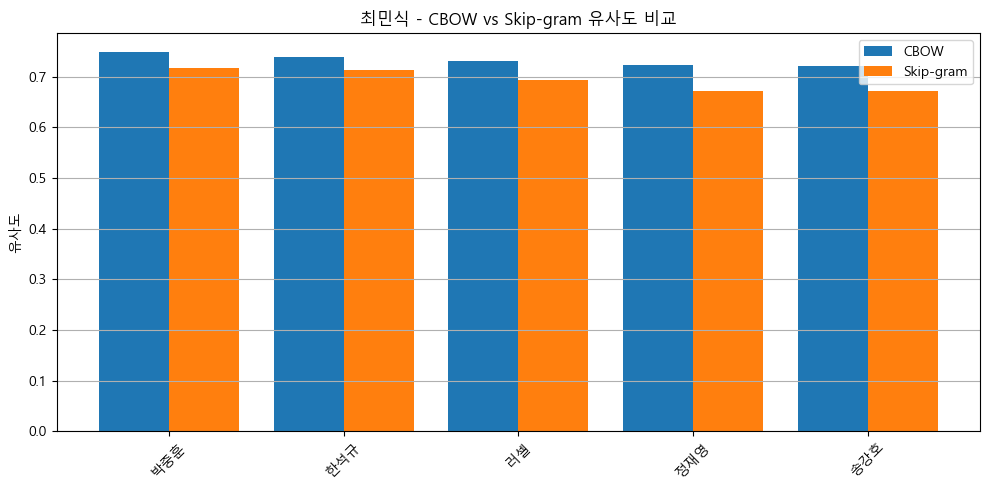

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# 한글 폰트 설정 (윈도우용)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 최민식 그래프
df_min = df_result[df_result['기준단어'] == '최민식']

plt.figure(figsize=(10, 5))
x = range(len(df_min))
plt.bar(x, df_min['CBOW_유사도'], width=0.4, label='CBOW', align='center')
plt.bar([i + 0.4 for i in x], df_min['Skipgram_유사도'], width=0.4, label='Skip-gram', align='center')
plt.xticks([i + 0.2 for i in x], df_min['CBOW_유사단어'], rotation=45)
plt.title('최민식 - CBOW vs Skip-gram 유사도 비교')
plt.ylabel('유사도')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()

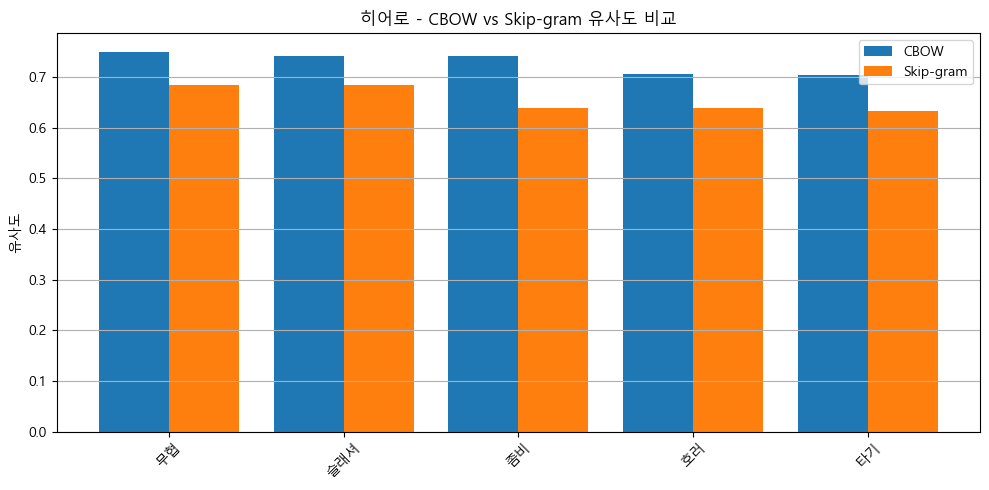

In [13]:
df_hero = df_result[df_result['기준단어'] == '히어로']

plt.figure(figsize=(10, 5))
x = range(len(df_hero))
plt.bar(x, df_hero['CBOW_유사도'], width=0.4, label='CBOW', align='center')
plt.bar([i + 0.4 for i in x], df_hero['Skipgram_유사도'], width=0.4, label='Skip-gram', align='center')
plt.xticks([i + 0.2 for i in x], df_hero['CBOW_유사단어'], rotation=45)
plt.title('히어로 - CBOW vs Skip-gram 유사도 비교')
plt.ylabel('유사도')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()